# Calibration of SGLD hyperparameters for MNIST

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/timaeus-research/devinterp/blob/main/examples/sgld_calibration.ipynb)

**NOTE: this notebook is outdated, check out [`epsilon_beta.ipynb`](../examples/epsilon_beta.ipynb)[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/timaeus-research/devinterp/blob/main/examples/epsilon_beta.ipynb) for a more up-to-date method of calibrating hyperparameters  $\epsilon$ and  $\beta$. (Note that `num_draws` can still be calibrated using the heuristics in this notebook.)**

**This notebook takes a while to run, and therefore is not intended to be run as part of the demo.**

This notebook walks through the process for calibrating hyperparameters for Stochastic Gradient Langevin Dynamics (SGLD) based LLC (or $\hat\lambda$) estimation. The model we'll use is a small 2-layer ReLU network (~1M params) trained on the MNIST dataset.

Note that in this case, the theoretical value of the LLC is not known. The intent of this notebook is to demonstrate that, even when we don't have access to the ground truth $\lambda$, there are diagnostic processes that can allow us to be more confident that $\hat\lambda$ preserves desirable properties of $\lambda$, such as maintaining relative ordering of degeneracy. This also reflects most real-world situations where we're interested in $\hat\lambda$ estimations.

Finally, we should emphasize that this is more an art than a science. There is still a great deal of uncertainty and many unknown unknowns. The process of LLC estimation is a **work in progress**, and this notebook only reflects the best state of our knowledge at the time of the creation of this notebook.

This notebook is split into 5 sections:
1. Data preparation
2. Training model checkpoints
3. Running calibration sweep
4. Plotting LLC estimations over time
5. Selecting $\epsilon$ and $\gamma$

In [1]:
%pip install --upgrade pip
%pip install torch torchvision
%pip install devinterp

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import copy

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from tqdm import tqdm

from devinterp.optim.sgld import SGLD
from devinterp.slt.mala import MalaAcceptanceRate
from devinterp.slt.sampler import estimate_learning_coeff_with_summary
from devinterp.utils import evaluate_ce, default_nbeta

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

NUM_CHAINS = 8
NUM_DRAWS = 2000

plt.rcParams["figure.figsize"] = (
    15,
    12,
)  # note: this cell may need to be re-run after creating a plot to take effect

In [ ]:
# Define the neural network
class MNIST(nn.Module):
    def __init__(
        self,
        hidden_layer_sizes=[1024, 1024],
        input_dim=28 * 28,
        output_dim=10,
        activation=F.relu,
        with_bias=True,
    ):
        super(MNIST, self).__init__()
        self.input_dim = input_dim
        self.layer_sizes = [input_dim] + hidden_layer_sizes + [output_dim]
        self.activation = activation
        self.with_bias = with_bias
        self.layers = nn.ModuleList()
        for i in range(len(self.layer_sizes) - 1):
            dim_in, dim_out = self.layer_sizes[i : i + 2]
            self.layers.append(nn.Linear(dim_in, dim_out, bias=self.with_bias).float())

    def forward(self, x):
        x = x.view(-1, self.input_dim)
        for layer in self.layers[:-1]:
            x = self.activation(layer(x))
        x = self.layers[-1](x)
        return x


# Train/test utils
def train_one_epoch(model, train_loader, optimizer, criterion):
    model.train()
    train_loss = 0
    for data, target in tqdm(train_loader):
        optimizer.zero_grad()
        output = model(data.to(DEVICE))
        loss = criterion(output, target.to(DEVICE))
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
    return train_loss / len(train_loader)


def evaluate(model, test_loader, criterion):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = model(data.to(DEVICE))
            loss = criterion(output, target.to(DEVICE))
            test_loss += loss.item()
    return test_loss / len(test_loader)

### 1. Data preparation

In [ ]:
# Load MNIST data
batch_size = 512
train_data = datasets.MNIST(
    "../data", train=True, transform=transforms.ToTensor(), download=True
)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
print(len(train_data))
# Load test data
test_data = datasets.MNIST("../data", train=False, transform=transforms.ToTensor())
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)
# Initialize model, loss, optimizer and sgld sampler
model = MNIST().to(DEVICE)
criterion = nn.CrossEntropyLoss()
lr = 0.05
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, nesterov=True)
n_epochs = 15

60000


### 2. Training model checkpoints

In [ ]:
# train model
train_losses = []
test_losses = []
checkpoints = []
for epoch in range(n_epochs):
    train_loss = train_one_epoch(model, train_loader, optimizer, criterion)
    test_loss = evaluate(model, test_loader, criterion)
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    checkpoints += [copy.deepcopy(model)]
    print(f"Epoch {epoch+1}, Train Loss: {train_loss}, Test Loss: {test_loss}")

100%|██████████| 118/118 [00:08<00:00, 13.67it/s]


Epoch 1, Train Loss: 0.6961577100268865, Test Loss: 0.2755667187273502


100%|██████████| 118/118 [00:08<00:00, 13.72it/s]


Epoch 2, Train Loss: 0.2325787971711765, Test Loss: 0.18936889730393885


100%|██████████| 118/118 [00:08<00:00, 13.78it/s]


Epoch 3, Train Loss: 0.1642560908981299, Test Loss: 0.1447964208200574


100%|██████████| 118/118 [00:08<00:00, 13.84it/s]


Epoch 4, Train Loss: 0.12386205574592292, Test Loss: 0.11548007428646087


100%|██████████| 118/118 [00:08<00:00, 13.77it/s]


Epoch 5, Train Loss: 0.09761389427013316, Test Loss: 0.10598343191668391


100%|██████████| 118/118 [00:08<00:00, 14.11it/s]


Epoch 6, Train Loss: 0.07895224992880377, Test Loss: 0.09333303300663828


100%|██████████| 118/118 [00:08<00:00, 14.07it/s]


Epoch 7, Train Loss: 0.06505178098203772, Test Loss: 0.0757683047093451


100%|██████████| 118/118 [00:08<00:00, 13.90it/s]


Epoch 8, Train Loss: 0.053109435680306565, Test Loss: 0.07709892550483347


100%|██████████| 118/118 [00:08<00:00, 13.60it/s]


Epoch 9, Train Loss: 0.046335753400699564, Test Loss: 0.06573324371129274


100%|██████████| 118/118 [00:08<00:00, 13.53it/s]


Epoch 10, Train Loss: 0.03854203184719308, Test Loss: 0.07850201493129134


100%|██████████| 118/118 [00:08<00:00, 13.71it/s]


Epoch 11, Train Loss: 0.03294009649021141, Test Loss: 0.06791895171627402


100%|██████████| 118/118 [00:08<00:00, 14.15it/s]


Epoch 12, Train Loss: 0.028329799969885813, Test Loss: 0.06756850690580904


100%|██████████| 118/118 [00:08<00:00, 13.63it/s]


Epoch 13, Train Loss: 0.023483506269689838, Test Loss: 0.07217952976934612


100%|██████████| 118/118 [00:08<00:00, 13.52it/s]


Epoch 14, Train Loss: 0.020007405201194144, Test Loss: 0.06043984862044453


100%|██████████| 118/118 [00:08<00:00, 13.82it/s]


Epoch 15, Train Loss: 0.016724266253916893, Test Loss: 0.05954055767506361


Plotting the train and test loss shows that training has not entirely converged, but still we should be able to get reasonable LLC estimates if we tune our hyperparameters correctly.

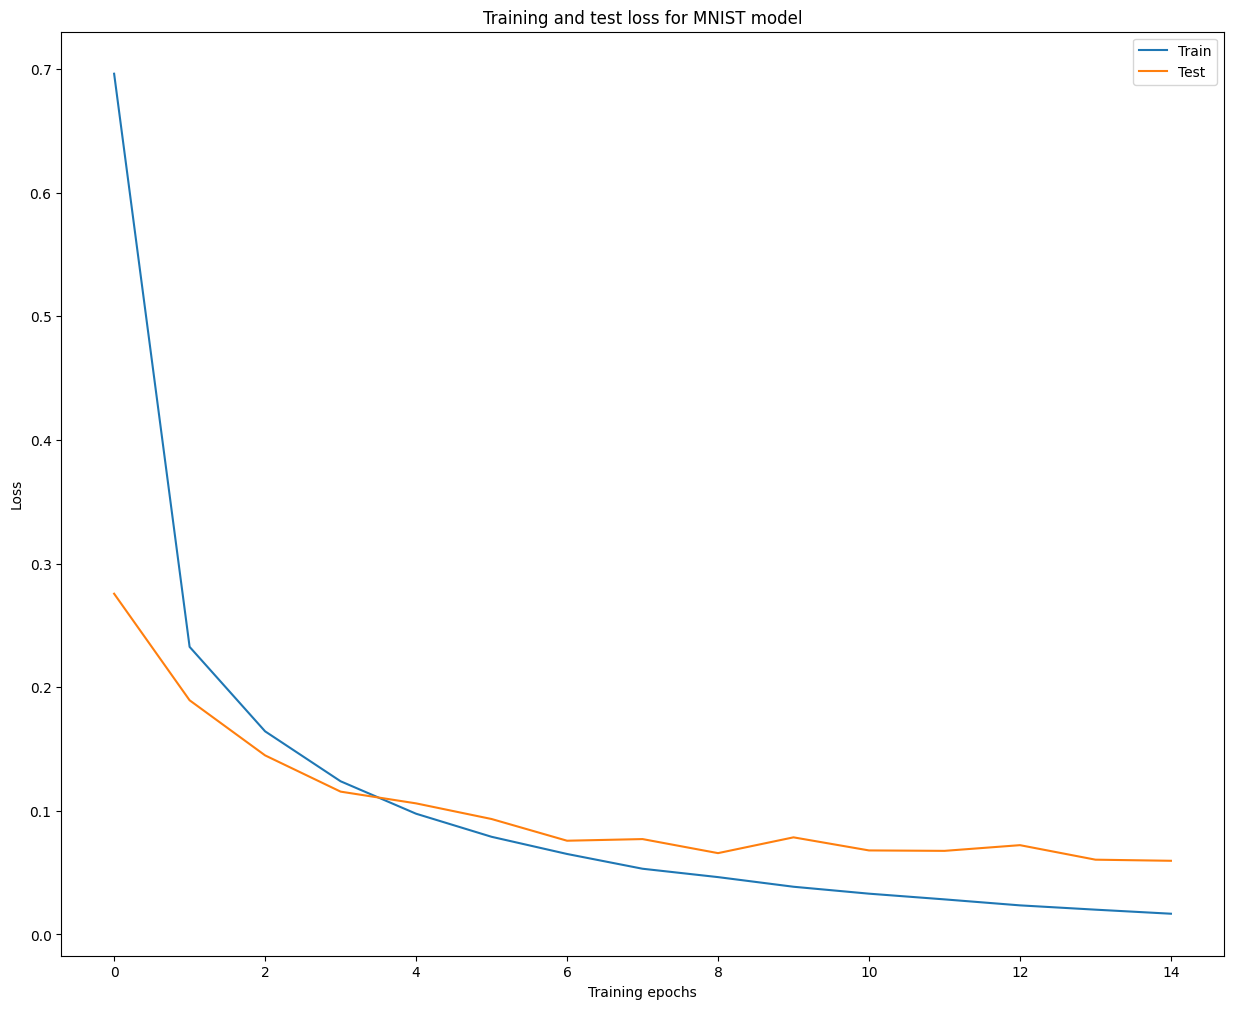

In [ ]:
import matplotlib.pyplot as plt

epochs = list(range(n_epochs))
plt.plot(epochs, train_losses, label="Train")
plt.plot(epochs, test_losses, label="Test")
plt.xlabel("Training epochs")
plt.ylabel("Loss")
plt.title("Training and test loss for MNIST model")
plt.legend()
plt.show()

### 3. Running calibration sweep

The main idea is to sweep across orders of magnitude of learning rate (epsilon) and localization (gamma). We look at the mean of LLC estimations over time by looking at the average estimated LLC for each chain at a given time step. A reasonable starting point for sweeping is to use `[1e-5, 1e-4, 1e-3]` for epsilon values and `[1, 10, 100]` for gamma values.

In [7]:
EPSILONS = [1e-5, 1e-4, 1e-3]
GAMMAS = [1, 10, 100]
plt.rcParams["figure.figsize"] = (15, 12)


def estimate_llcs_sweeper(model, epsilons, gammas):
    results = {}
    for epsilon in epsilons:
        for gamma in gammas:
            optim_kwargs = dict(lr=epsilon, noise_level=1.0, localization=gamma)
            pair = (epsilon, gamma)
            results[pair] = estimate_learning_coeff_with_summary(
                model=model,
                loader=train_loader,
                evaluate=evaluate_ce,
                sampling_method=SGLD,
                optimizer_kwargs=optim_kwargs,
                num_chains=NUM_CHAINS,
                num_draws=NUM_DRAWS,
                device=DEVICE,
                online=True,
            )
    return results


def plot_single_graph(result, title=""):
    llc_color = "teal"
    fig, axs = plt.subplots(1, 1)
    # plot loss traces
    loss_traces = result["loss/trace"]
    for trace in loss_traces:
        init_loss = trace[0]
        zeroed_trace = trace - init_loss
        sgld_steps = list(range(len(trace)))
        axs.plot(sgld_steps, zeroed_trace)

    # plot llcs
    means = result["llc/means"]
    stds = result["llc/stds"]
    sgld_steps = list(range(len(means)))
    axs2 = axs.twinx()
    axs2.plot(
        sgld_steps,
        means,
        color=llc_color,
        linestyle="--",
        linewidth=2,
        label=f"llc",
        zorder=3,
    )
    axs2.fill_between(
        sgld_steps, means - stds, means + stds, color=llc_color, alpha=0.3, zorder=2
    )

    # center zero, assume zero is in the range of both y axes already
    y1_min, y1_max = axs.get_ylim()
    y2_min, y2_max = axs2.get_ylim()
    y1_zero_ratio = abs(y1_min) / (abs(y1_min) + abs(y1_max))
    y2_zero_ratio = abs(y2_min) / (abs(y2_min) + abs(y2_max))
    percent_to_add = abs(y1_zero_ratio - y2_zero_ratio)
    y1_amt_to_add = (y1_max - y1_min) * percent_to_add
    y2_amt_to_add = (y2_max - y2_min) * percent_to_add
    if y1_zero_ratio < y2_zero_ratio:
        # add to bottom of y1 and top of y2
        y1_min -= y1_amt_to_add
        y2_max += y2_amt_to_add
    elif y2_zero_ratio < y1_zero_ratio:
        # add to bottom of y2 and top of y1
        y2_min -= y2_amt_to_add
        y1_max += y1_amt_to_add
    axs.set_ylim(y1_min, y1_max)
    axs2.set_ylim(y2_min, y2_max)
    axs.set_xlabel("SGLD time step")
    axs.set_ylabel("loss")
    axs2.set_ylabel("llc", color=llc_color)
    axs2.tick_params(axis="y", labelcolor=llc_color)
    axs.axhline(color="black", linestyle=":")
    fig.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()


def plot_sweep_single_model(results, epsilons, gammas, **kwargs):
    llc_color = "teal"
    fig, axs = plt.subplots(len(epsilons), len(gammas))

    for i, epsilon in enumerate(epsilons):
        for j, gamma in enumerate(gammas):
            result = results[(epsilon, gamma)]
            # plot loss traces
            loss_traces = result["loss/trace"]
            for trace in loss_traces:
                init_loss = trace[0]
                zeroed_trace = trace - init_loss
                sgld_steps = list(range(len(trace)))
                axs[i, j].plot(sgld_steps, zeroed_trace)

            # plot llcs
            means = result["llc/means"]
            stds = result["llc/stds"]
            sgld_steps = list(range(len(means)))
            axs2 = axs[i, j].twinx()
            axs2.plot(
                sgld_steps,
                means,
                color=llc_color,
                linestyle="--",
                linewidth=2,
                label=f"llc",
                zorder=3,
            )
            axs2.fill_between(
                sgld_steps,
                means - stds,
                means + stds,
                color=llc_color,
                alpha=0.3,
                zorder=2,
            )

            # center zero, assume zero is in the range of both y axes already
            y1_min, y1_max = axs[i, j].get_ylim()
            y2_min, y2_max = axs2.get_ylim()
            y1_zero_ratio = abs(y1_min) / (abs(y1_min) + abs(y1_max))
            y2_zero_ratio = abs(y2_min) / (abs(y2_min) + abs(y2_max))
            percent_to_add = abs(y1_zero_ratio - y2_zero_ratio)
            y1_amt_to_add = (y1_max - y1_min) * percent_to_add
            y2_amt_to_add = (y2_max - y2_min) * percent_to_add
            if y1_zero_ratio < y2_zero_ratio:
                # add to bottom of y1 and top of y2
                y1_min -= y1_amt_to_add
                y2_max += y2_amt_to_add
            elif y2_zero_ratio < y1_zero_ratio:
                # add to bottom of y2 and top of y1
                y2_min -= y2_amt_to_add
                y1_max += y1_amt_to_add
            axs[i, j].set_ylim(y1_min, y1_max)
            axs2.set_ylim(y2_min, y2_max)

            axs[i, j].set_title(f"$\epsilon$ = {epsilon} : $\gamma$ = {gamma}")
            # only show x axis label on last row
            if i == len(epsilons) - 1:
                axs[i, j].set_xlabel("SGLD time step")
            axs[i, j].set_ylabel("loss")
            axs2.set_ylabel("llc", color=llc_color)
            axs2.tick_params(axis="y", labelcolor=llc_color)
    if kwargs["title"]:
        fig.suptitle(kwargs["title"], fontsize=16)
    plt.tight_layout()
    plt.show()

In [8]:
EPSILONS = [1e-3, 1e-4, 1e-5]
GAMMAS = [100.0, 1.0]
NUM_CHAINS = 1
NUM_DRAWS = 500
results = {}


def estimate_mala_sweeper(model):
    for epsilon in EPSILONS:
        for gamma in GAMMAS:
            mala_estimator = MalaAcceptanceRate(
                num_chains=NUM_CHAINS,
                num_draws=NUM_DRAWS,
                nbeta=default_nbeta(train_loader),
                learning_rate=epsilon,
                device=DEVICE,
            )

            result = estimate_learning_coeff_with_summary(
                model,
                train_loader,
                evaluate=evaluate_ce,
                optimizer_kwargs=dict(
                    lr=epsilon,
                    localization=gamma,
                    nbeta=default_nbeta(train_loader),
                ),
                sampling_method=SGLD,
                num_chains=NUM_CHAINS,
                num_draws=NUM_DRAWS,
                callbacks=[mala_estimator],
                verbose=False,
                online=True,
            )
            mala_acceptance_rate_mean = mala_estimator.get_results()["mala_accept/mean"]
            results[(epsilon, gamma)] = result
            print(
                f"epsilon {epsilon}, gamma {gamma}, mala rate: {mala_acceptance_rate_mean}"
            )


estimate_mala_sweeper(model)

/home/will/Kaggle/important/Timaeus/devinterp/src/devinterp/slt/sampler.py:199: UserWarning: You are taking more draws than burn-in steps, your LLC estimates will likely be underestimates. Please check LLC chain convergence.
  warnings.warn(
/home/will/Kaggle/important/Timaeus/devinterp/src/devinterp/slt/sampler.py:203: UserWarning: You are taking more sample batches than there are dataloader batches available, this removes some randomness from sampling but is probably fine. (All sample batches beyond the number dataloader batches are cycled from the start, f.e. 9 samples from [A, B, C] would be [B, A, C, B, A, C, B, A, C].)
  warnings.warn(
/home/will/Kaggle/important/Timaeus/devinterp/src/devinterp/slt/sampler.py:52: UserWarning: You are taking more sample batches than there are dataloader batches available, this removes some randomness from sampling but is probably fine. (All sample batches beyond the number dataloader batches are cycled from the start, f.e. 9 samples from [A, B, C]

Using passed in nbeta. Make sure callbacks are also initialized with the same nbeta.


/home/paperspace/devinterp/src/devinterp/backends/default/slt/sampler.py:208: UserWarning: You are taking more draws than burn-in steps, your LLC estimates will likely be underestimates. Please check LLC chain convergence.
  warnings.warn(
/home/paperspace/devinterp/src/devinterp/backends/default/slt/sampler.py:212: UserWarning: You are taking more sample batches than there are dataloader batches available, this removes some randomness from sampling but is probably fine. (All sample batches beyond the number dataloader batches are cycled from the start, f.e. 9 samples from [A, B, C] would be [B, A, C, B, A, C, B, A, C].)
  warnings.warn(
/home/paperspace/devinterp/src/devinterp/backends/default/slt/sampler.py:52: UserWarning: You are taking more sample batches than there are dataloader batches available, this removes some randomness from sampling but is probably fine. (All sample batches beyond the number dataloader batches are cycled from the start, f.e. 9 samples from [A, B, C] would

If you're setting a nbeta in optimizer_kwargs, please also make sure to set it in the callbacks.
epsilon 0.001, gamma 100.0, mala rate: 0.05232007056474686
Using passed in nbeta. Make sure callbacks are also initialized with the same nbeta.
If you're setting a nbeta in optimizer_kwargs, please also make sure to set it in the callbacks.
epsilon 0.001, gamma 1.0, mala rate: 0.03671271726489067
Using passed in nbeta. Make sure callbacks are also initialized with the same nbeta.
If you're setting a nbeta in optimizer_kwargs, please also make sure to set it in the callbacks.
epsilon 0.0001, gamma 100.0, mala rate: 0.3139558434486389
Using passed in nbeta. Make sure callbacks are also initialized with the same nbeta.
If you're setting a nbeta in optimizer_kwargs, please also make sure to set it in the callbacks.
epsilon 0.0001, gamma 1.0, mala rate: 0.4310963451862335
Using passed in nbeta. Make sure callbacks are also initialized with the same nbeta.
If you're setting a nbeta in optimizer_k

Judging by this, $\epsilon = 1e^{-2}$ is out (did not converge), and a $\gamma$ of $1$ is too low. A higher MALA acceptance prob would be better (ideally we'd aim for $.9$) but that might not be possible for this model. The higher learning rate is generally preferred, but we have to be careful not to get a thermalization peak at the start of sampling. Let's take a look at the loss curves next to check if our sampling works as expected.

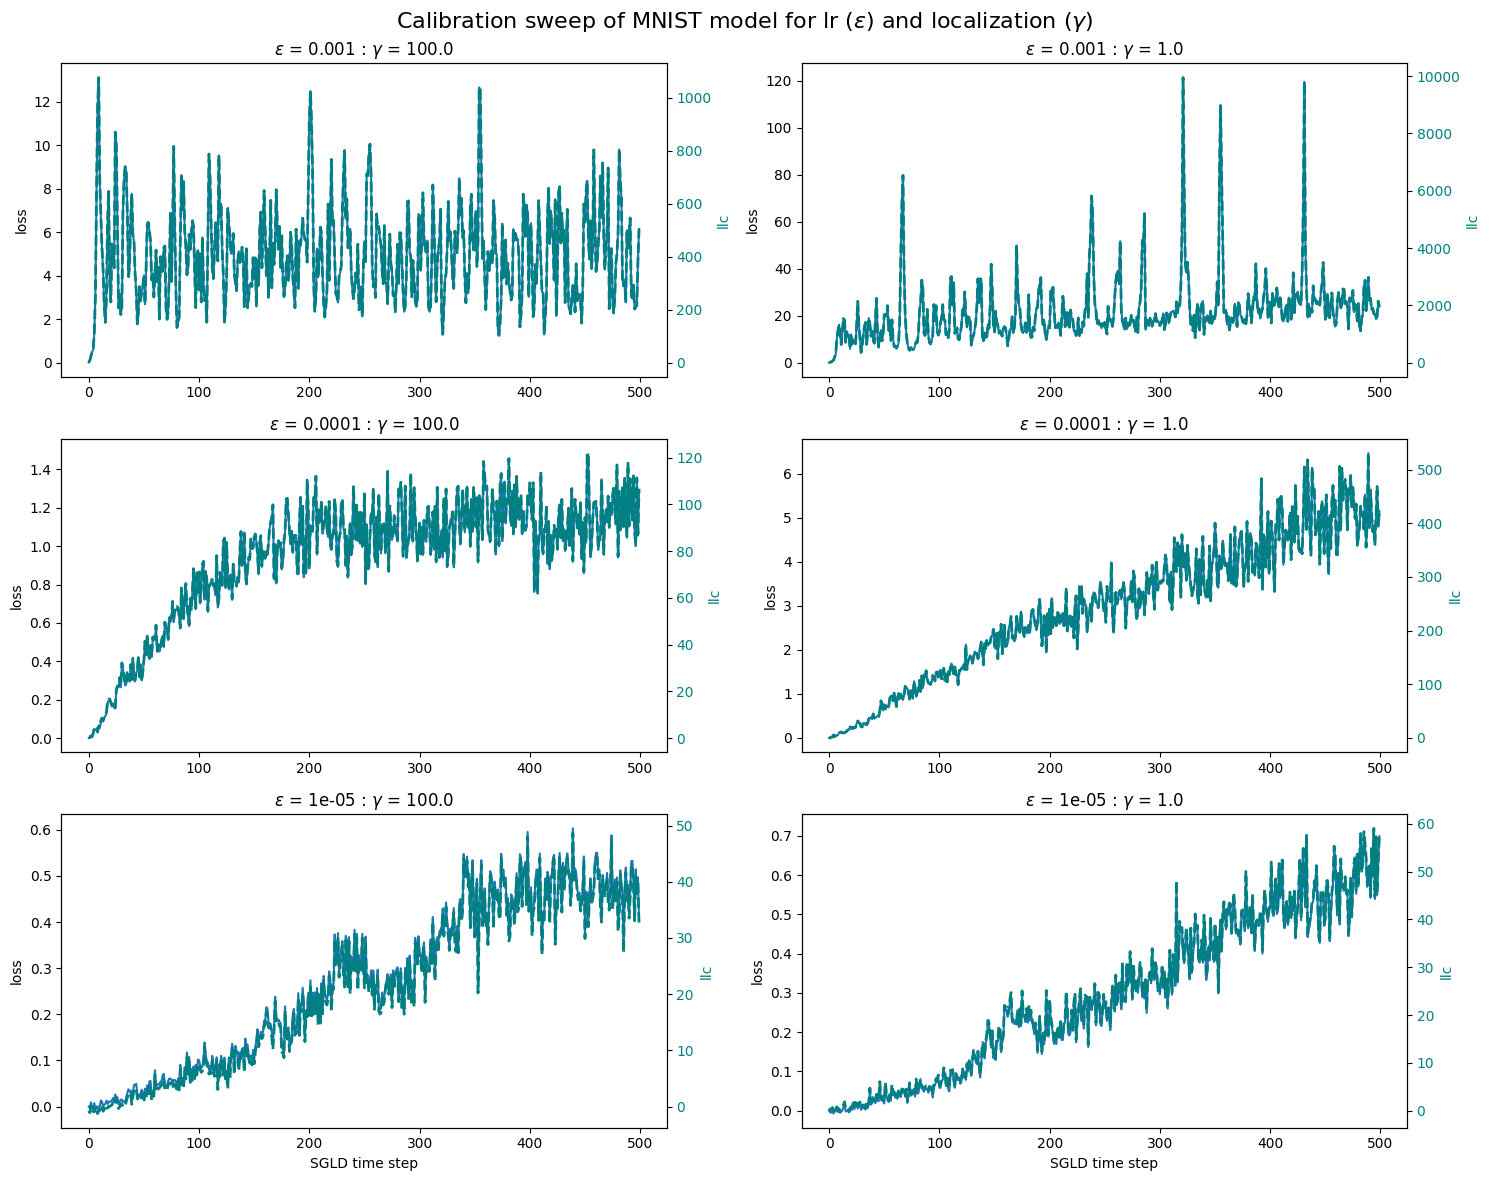

In [9]:
plot_sweep_single_model(
    results,
    EPSILONS,
    GAMMAS,
    title="Calibration sweep of MNIST model for lr ($\\epsilon$) and localization ($\\gamma$)",
)

In these graphs, the LLC estimation mean is shown as a teal dotted line, and the standard deviation is shown as a shaded teal area around the mean. The remaining lines are the loss trace for each estimation. These are plotted with a shared $y=0$ line and have different scales of y axis (which can be seen on the left and right sides of each subplot).


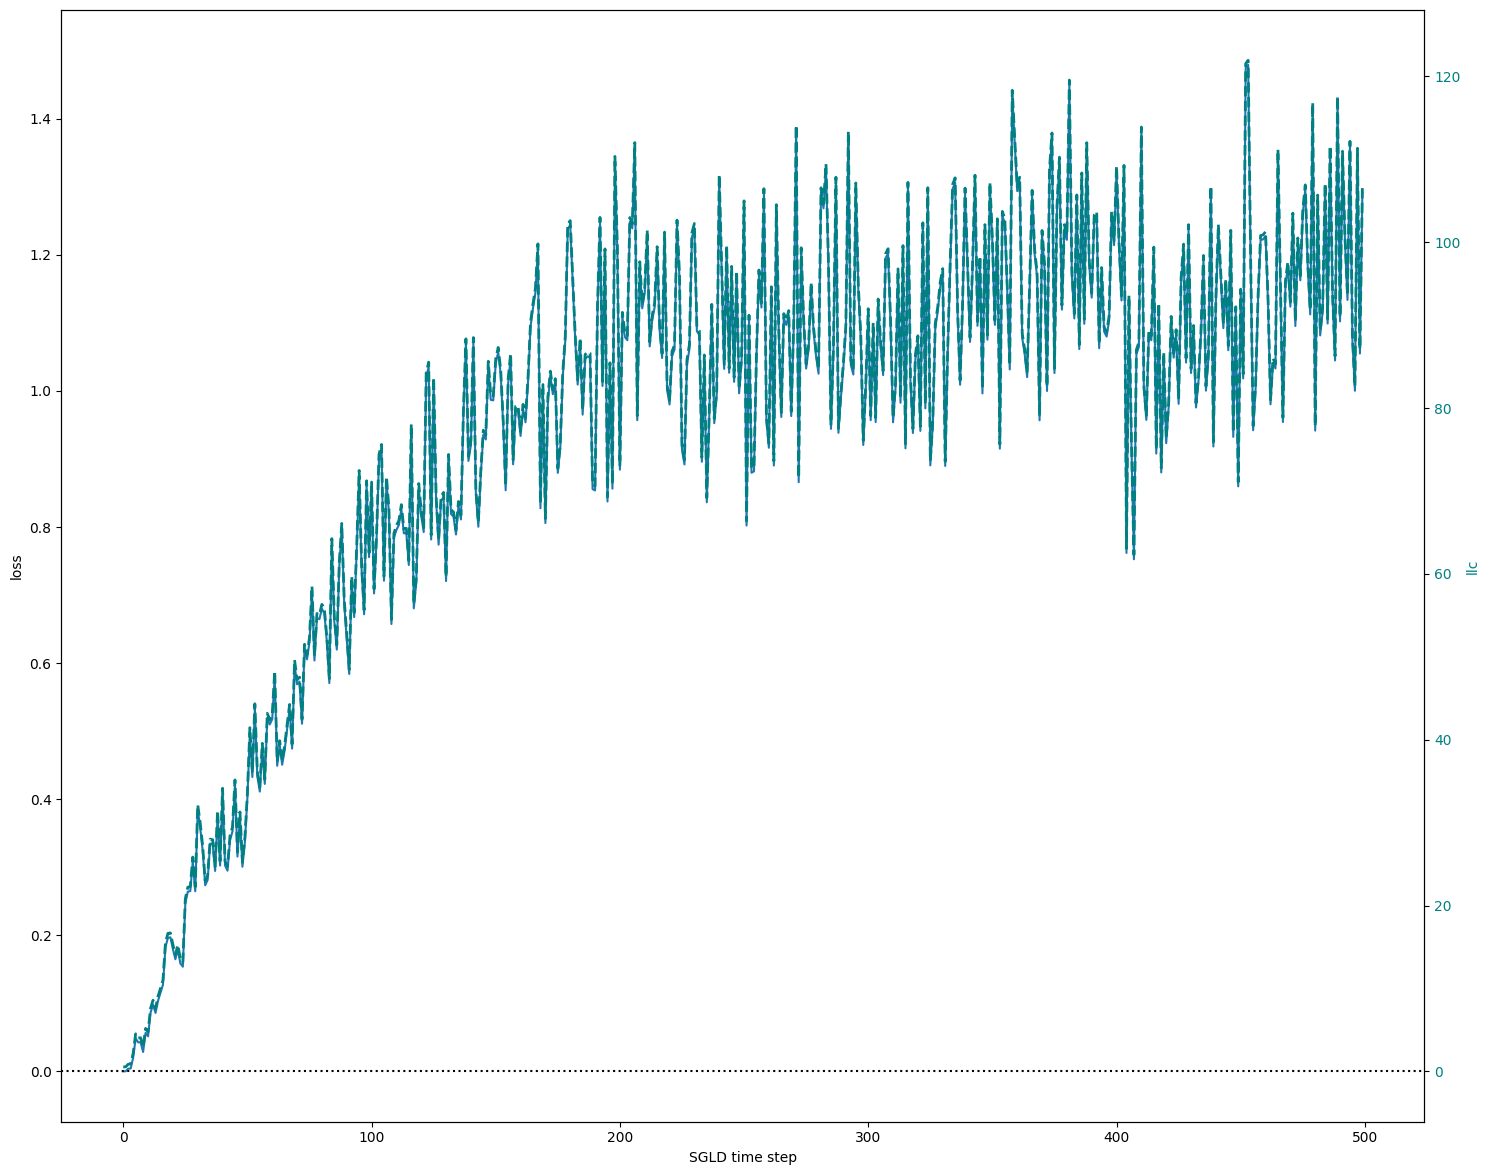

In [10]:
epsilon = 1e-4
gamma = 100
result = results[(epsilon, gamma)]
plot_single_graph(result)

This trace clearly has not converged yet, but looks healthy thus far (no big spikes, no flatlining).

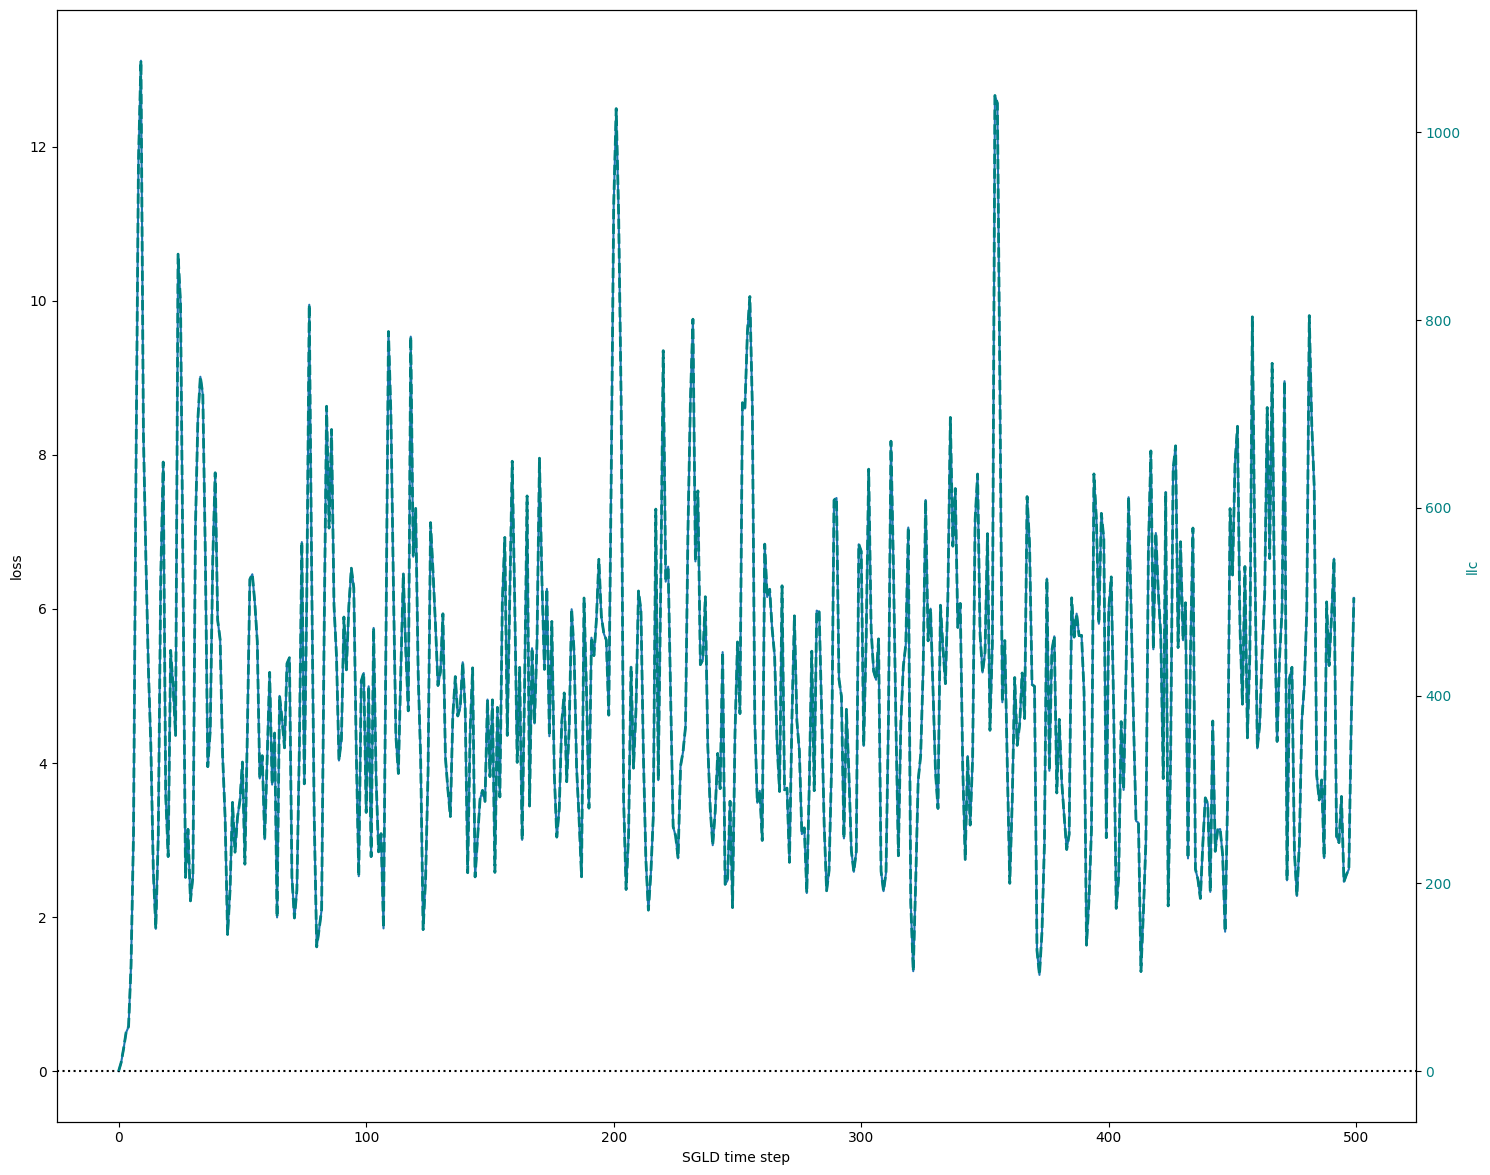

In [11]:
epsilon = 1e-3
gamma = 100
result = results[(epsilon, gamma)]
plot_single_graph(result)

In this case, there are big spikes in the loss trace. In some models, this shape of LLC curve might happen because the SGLD sampling process is actually continuing to train the model, however in that case, we'd expect the loss traces to drop below the initial loss. In this example, the losses still remain positive after the initial spike, so it doesn't appear that SGLD is turning into continued training. It is currently unclear whether a spike (or in general, a not-monotonically-increasing curve) is a reason to invalidate a set of parameters, but it may be safest to consider it a yellow flag and pick a better set of parameters if possible.

**In general, the loss traces are a useful diagnostic tool and should be the second thing to check (after MALA prob) when there's odd behavior in your LLC estimation.**

Let's try running more samples on the $\epsilon=1e^{-4},\ \gamma=100$ case to see if it flattens out.

In [12]:
optim_kwargs = dict(lr=1e-4, localization=100)
result = estimate_learning_coeff_with_summary(
    model=checkpoints[-1],
    loader=train_loader,
    evaluate=evaluate_ce,
    sampling_method=SGLD,
    optimizer_kwargs=optim_kwargs,
    num_chains=6,
    num_draws=5000,
    device=DEVICE,
    online=True,
)

nbeta not set - using default nbeta.


If you're setting a nbeta in optimizer_kwargs, please also make sure to set it in the callbacks.


Chain 5: 100%|██████████| 5000/5000 [00:34<00:00, 143.19it/s]


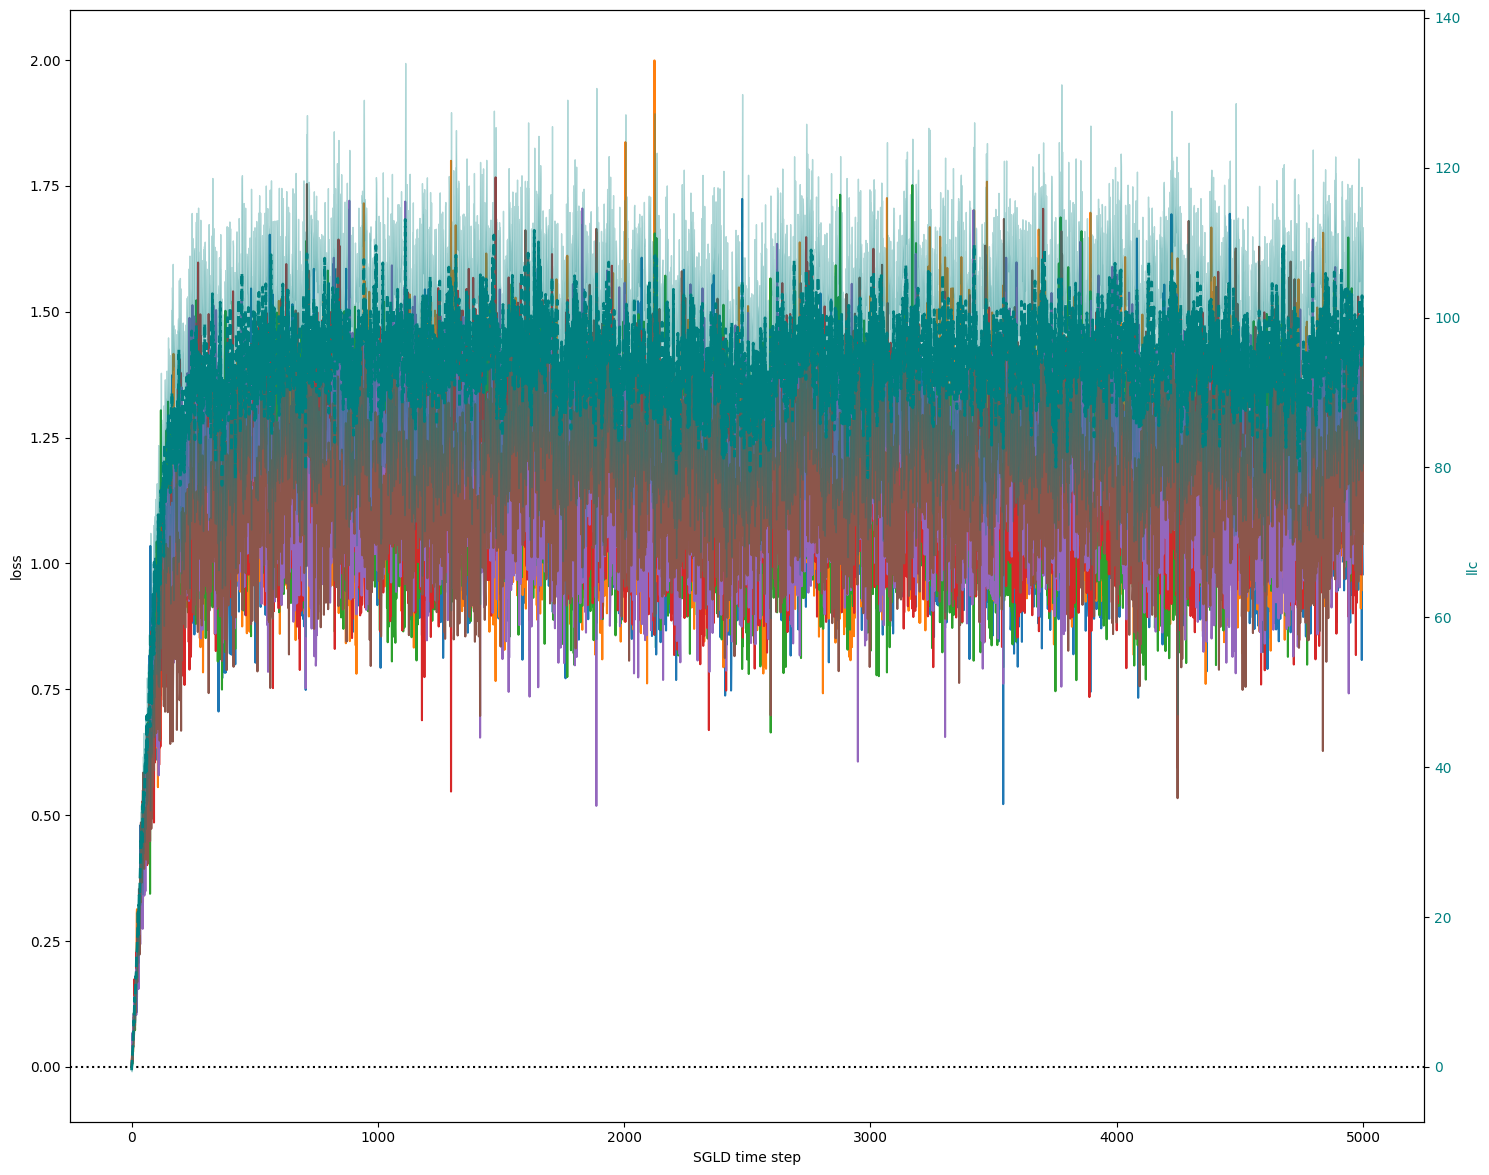

In [13]:
plot_single_graph(result)

### 5. Heuristics for selecting $\epsilon$ and $\gamma$

There is currently no One True Set of hyperparameters. Instead, the goal of calibration is to identify hyperparameters that maintain certain desirable properties. Some general such heuristics:
- Optimal traces should converge.
- Absolute $\hat\lambda$ estimates are not as important as relative $\hat\lambda$ estimates.
- The most important feature is that the relative ordering of estimates is maintained if you have different models to compare (e.g. different checkpoints).
- The MALA acceptance criterion should be as close as possible to $.9$ (but don't worry if you can't reach that). MALA acceptance probs of $0$ and $1$ are indications of unhealthy chains.
- The graph should not have negative dips (or not dip negative for very long).
- You can also examine the loss traces or other diagnostics to check that they look healthy (f.e. No Starting Peak), such as in the examples above.
  - A good set of loss traces should stay above the initial loss value (or at least not drop below it too far or for too many steps) and should not diverge away from the initial loss value.

If you don't get good results on the first sweep, you might recenter your sweep and try again.

### 6. Selecting $\epsilon$ and $\gamma$ in this MNIST example

- $\epsilon=1e^{-2}$ is definitely a no-go, since the values quickly diverge to NaN.
- $\epsilon=1e^{-3}$ causes a big spike in the initial LLC estimation. This should be avoided.
- With enough draws, the LLC estimation for $\epsilon=1e^{-4}, \ \gamma=1$ looks like it will converge nicely. The loss traces are basically flattened out as well, which is another indication that the LLC estimation should continue to converge without issue. In this first sweep, this would be my recommendation for hyperparameters.
- If more refinement is needed (e.g. it's necessary for LLC estimation to converge in a fewer number of draws), then another option would be to sweep with more granular values (say, a half order of magnitude) around $\epsilon=1e^{-4}, \ \gamma=1$